In [3]:
import pandas as pd
import numpy as np
import datetime
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#need to seperate the tag into different columns, melt the wide data into a long data, to find the frequency
#descritive question
#trending date need to convert
# 0:11

In [5]:
# load all the dataset into a single dataframe df

df = pd.concat([pd.read_csv('../../data/raw/CA_youtube_trending_data.csv'),pd.read_csv('../../data/raw/GB_youtube_trending_data.csv'),pd.read_csv('../../data/raw/US_youtube_trending_data.csv')])
#change the datetime
df["trending_date"] = df.apply(lambda row: pd.to_datetime(row["trending_date"]), axis=1)
df["publishedAt"] = df.apply(lambda row: pd.to_datetime(row["publishedAt"]), axis=1)
print(df)

          video_id                                              title  \
0      KX06ksuS6Xo  Diljit Dosanjh: CLASH (Official) Music Video |...   
1      J78aPJ3VyNs  I left youtube for a month and THIS is what ha...   
2      M9Pmf9AB4Mo  Apex Legends | Stories from the Outlands – “Th...   
3      3C66w5Z0ixs                 I ASKED HER TO BE MY GIRLFRIEND...   
4      VIUo6yapDbc  Ultimate DIY Home Movie Theater for The LaBran...   
...            ...                                                ...   
14593  7whb6qdbdlA                      Stray Kids 『ALL IN』M/V Teaser   
14594  rjwWG6kJ6io  NBC News hosts town hall with President Trump ...   
14595  KV3fVY0nHw4  Sada Baby - Whole Lotta Choppas [Remix] ft. Ni...   
14596  i3HS54oAxbY  Apple MagSafe Charger - Unboxing and Everythin...   
14597  xQOO2xGQ1Pc  Justin Bieber & benny blanco - Lonely (Officia...   

                    publishedAt                 channelId  \
0     2020-08-11 07:30:02+00:00  UCZRdNleCgW-BGUJf-bbjzQg   
1

In [6]:
#category ID dictionary
category_replace = {
      1:'Film & Animation',
      2:'Autos & Vehicles',
      10:'Music',
      15:'Pets & Animals',
      17:'Sports',
      19:'Travel & Events', 
      20:'Gaming',
      21:'Videoblogging',
      22: "People & Blogs",
      23: "Comedy", 
      24: "Entertainment",
      25: "News & Politics", 
      26: "Howto & Style", 
      27: "Education", 
      28: "Science & Technology",
      29: 'NaN'
    }

In [7]:
#clean the dataset
df_clean = df.drop(columns = ['thumbnail_link','comments_disabled','ratings_disabled','channelId'])
df_clean = df_clean.replace({"categoryId":category_replace}).rename(columns= {'categoryId':'category'})
df_clean = df_clean.drop(df_clean[df_clean['category']=='NaN'].index).sort_values('trending_date')
df_clean = df_clean[df_clean['likes'] != 0]
df_clean = df_clean.reset_index().drop(columns = ['index'])
#turn tags into actual list
df_clean["tags"] = df_clean.apply(lambda row: row["tags"].split("|"), axis=1)
#calculate the videos' like to dislike ratio (assuming that there are likes and dislikes)
df_clean["ratio"] = df_clean.apply(lambda row: 0 if row["dislikes"]==0 else (row["likes"]/row["dislikes"]), axis=1)
df_clean["log_views"] = df_clean.apply(lambda row: 0 if row["view_count"]==0 else np.log(row["view_count"]), axis=1)
#print(df_clean)

*In the dataset, a video_id has one publish date and mutiple trending dates.
I would like to keep each video to have only one record so that we can define which types of video is most popular.*

In [8]:
#drop the duplicate video and keep the video with the last trending_date
df_lastdate = df_clean.drop_duplicates(['video_id'], keep='last').reset_index().drop(columns = 'index')

#print(df_lastdate)


#Identifying outliers
#print(df_lastdate.loc[df_lastdate['comment_count'] == 6064909])

In [9]:
df_lastdate.profile_report()

In [10]:
#analysis
tagRatios = {}
for index, row in df_lastdate.iterrows():
    if row["ratio"]==0:
        continue
    for i in row["tags"]:
        if i in tagRatios:
            tagRatios[i][0]+=row["likes"]
            tagRatios[i][1]+=row["dislikes"]
        else:
            tagRatios[i] = [row["likes"],row["dislikes"]]
for i in tagRatios:
    tagRatios[i] = dataCrime[i][0]/dataCrime[i][1]
#print(tagRatios)

In [11]:
#print([(i, tagRatios[i]) for i in {k: v for k, v in sorted(tagRatios.items(), key=lambda item: item[1])}])
#currently commented because it takes up such a large amount of space
#ordered list of tags by like/dislike ratio
#people like kpop and dislike bon appetit

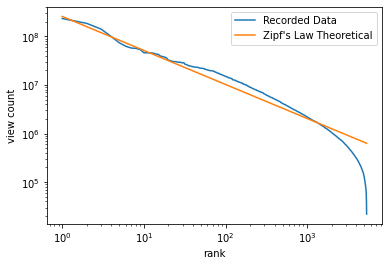

In [12]:
s=0.7
denom = sum([1/i**s for i in range(1,1+len(df_lastdate["view_count"].tolist()))])
plt.loglog(range(1,1+len(df_lastdate["view_count"].tolist())), sorted(df_lastdate["view_count"].tolist())[::-1])
plt.loglog(range(1,1+len(df_lastdate["view_count"].tolist())),[sum(df_lastdate["view_count"].tolist())*((1/k**s)/denom) for k in range(1,1+len(df_lastdate["view_count"].tolist()))])
plt.ylabel('view count')
plt.xlabel('rank')
plt.legend(['Recorded Data',"Zipf's Law Theoretical"])

In [ ]:
# view count does follow Zipf's law https://en.wikipedia.org/wiki/Zipf%27s_law

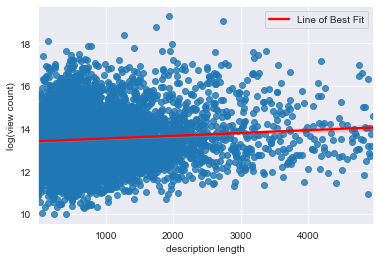

In [18]:
sns.regplot(x = df_lastdate.apply(lambda row: len(str(row["description"])), axis=1), y = df_lastdate["log_views"],line_kws = {"color": "red"})
plt.xlabel("description length")
plt.ylabel("log(view count)")
plt.legend(['Line of Best Fit'])

In [ ]:
# there is no meaningful correlation between description length and view count

In [14]:
tagfreq = {}
for index, row in df_lastdate.iterrows():
    for i in row["tags"]:
        if i in tagfreq:
            tagfreq[i] += row["view_count"]
        else:
            tagfreq[i] = row["view_count"]
#print(tagfreq)

In [15]:
#print([(i, tagfreq[i]) for i in {k: v for k, v in sorted(tagfreq.items(), key=lambda item: item[1])}][::-1])

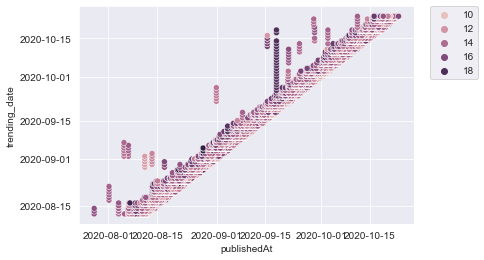

In [16]:
sns.set_style("darkgrid")
sns.scatterplot(x="publishedAt", y="trending_date", data = df_clean, hue = "log_views")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
#videos tend to trend around the same time they're uploaded
#I was expecting the outliers to have unusually high view counts to explain their staying power however that doesn't seem to be the case